# Deep Learning Model
## Luis Arturo
### A01703572

# Conexión a GPU local

In [60]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import re
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Test a simple GPU operation if available
if device.type == "cuda":
    try:
        # Create some random data on the GPU
        a = torch.randn(1000, 1000, device=device)
        b = torch.randn(1000, 1000, device=device)
        c = torch.matmul(a, b)  # Perform matrix multiplication
        print("✅ Successfully performed computation on GPU!")
        print(f"Matrix multiplication result shape: {c.shape}")
    except Exception as e:
        print("❌ Error during GPU computation:", e)
else:
    print("CUDA is not available. Running on CPU.")

Using device: cuda
✅ Successfully performed computation on GPU!
Matrix multiplication result shape: torch.Size([1000, 1000])


# ETL

## Carga de datos

In [4]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [5]:
# 1. EXTRACT - Carga de datos
print("=== CARGANDO DATASETS ===")
games_df = pd.read_csv('data/games.csv')
users_df = pd.read_csv('data/users.csv')
recommendations_df = pd.read_csv('data/recommendations.csv')

print("=== DATASETS CARGADOS ===")

=== CARGANDO DATASETS ===
=== DATASETS CARGADOS ===


## Información general del dataset

In [6]:
print("\nDimensiones del games_df:", games_df.shape)
print("\nColumnas disponibles del games_df:")
for col in games_df.columns:
    print(f"- {col}")


Dimensiones del games_df: (50872, 13)

Columnas disponibles del games_df:
- app_id
- title
- date_release
- win
- mac
- linux
- rating
- positive_ratio
- user_reviews
- price_final
- price_original
- discount
- steam_deck


In [7]:
print("\nDimensiones del users_df:", users_df.shape)
print("\nColumnas disponibles del users_df:")
for col in users_df.columns:
    print(f"- {col}")


Dimensiones del users_df: (14306064, 3)

Columnas disponibles del users_df:
- user_id
- products
- reviews


In [8]:
print("\nDimensiones del recommendations_df:", recommendations_df.shape)
print("\nColumnas disponibles del recommendations_df:")
for col in recommendations_df.columns:
    print(f"- {col}")


Dimensiones del recommendations_df: (41154794, 8)

Columnas disponibles del recommendations_df:
- app_id
- helpful
- funny
- date
- is_recommended
- hours
- user_id
- review_id


### Análisis inicial de games

In [9]:
print("\nPrimeras 5 filas de games_df:")
print(games_df.head())
print("\nInformación del dataset de juegos:")
print(games_df.info())
print("\nEstadísticas descriptivas de games_df:")
print(games_df.describe())
print("\nValores nulos en games_df:")
print(games_df.isnull().sum())


Primeras 5 filas de games_df:
   app_id                              title date_release   win    mac  linux  \
0   13500  Prince of Persia: Warrior Within™   2008-11-21  True  False  False   
1   22364            BRINK: Agents of Change   2011-08-03  True  False  False   
2  113020       Monaco: What's Yours Is Mine   2013-04-24  True   True   True   
3  226560                 Escape Dead Island   2014-11-18  True  False  False   
4  249050            Dungeon of the ENDLESS™   2014-10-27  True   True  False   

          rating  positive_ratio  user_reviews  price_final  price_original  \
0  Very Positive              84          2199         9.99            9.99   
1       Positive              85            21         2.99            2.99   
2  Very Positive              92          3722        14.99           14.99   
3          Mixed              61           873        14.99           14.99   
4  Very Positive              88          8784        11.99           11.99   

   disc

### Análisis inicial de users

In [10]:
print("\nPrimeras 5 filas de users_df:")
print(users_df.head())
print("\nInformación del dataset de usuarios:")
print(users_df.info())
print("\nEstadísticas descriptivas de users_df:")
print(users_df.describe())
print("\nValores nulos en users_df:")
print(users_df.isnull().sum())


Primeras 5 filas de users_df:
    user_id  products  reviews
0   7360263       359        0
1  14020781       156        1
2   8762579       329        4
3   4820647       176        4
4   5167327        98        2

Información del dataset de usuarios:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14306064 entries, 0 to 14306063
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   products  int64
 2   reviews   int64
dtypes: int64(3)
memory usage: 327.4 MB
None

Estadísticas descriptivas de users_df:
            user_id      products       reviews
count  1.430606e+07  1.430606e+07  1.430606e+07
mean   7.153032e+06  1.163734e+02  2.876738e+00
std    4.129805e+06  2.438515e+02  7.987421e+00
min    0.000000e+00  0.000000e+00  0.000000e+00
25%    3.576516e+06  2.300000e+01  1.000000e+00
50%    7.153032e+06  5.500000e+01  1.000000e+00
75%    1.072955e+07  1.270000e+02  3.000000e+00
max    1.430606e+07  3.221400e+04  6.045000e+03

Valores 

### Análisis inicial de recommendations

In [11]:
print("\nPrimeras 5 filas de recommendations_df:")
print(recommendations_df.head())
print("\nInformación del dataset de recomendaciones:")
print(recommendations_df.info())
print("\nEstadísticas descriptivas de recommendations_df:")
print(recommendations_df.describe())
print("\nValores nulos en recommendations_df:")
print(recommendations_df.isnull().sum())


Primeras 5 filas de recommendations_df:
    app_id  helpful  funny        date  is_recommended  hours  user_id  \
0   975370        0      0  2022-12-12            True   36.3    51580   
1   304390        4      0  2017-02-17           False   11.5     2586   
2  1085660        2      0  2019-11-17            True  336.5   253880   
3   703080        0      0  2022-09-23            True   27.4   259432   
4   526870        0      0  2021-01-10            True    7.9    23869   

   review_id  
0          0  
1          1  
2          2  
3          3  
4          4  

Información del dataset de recomendaciones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41154794 entries, 0 to 41154793
Data columns (total 8 columns):
 #   Column          Dtype  
---  ------          -----  
 0   app_id          int64  
 1   helpful         int64  
 2   funny           int64  
 3   date            object 
 4   is_recommended  bool   
 5   hours           float64
 6   user_id         int64  
 7  

### Análisis expecífico de features importantes

In [12]:
# Análisis de ratings
print("\nDistribución de ratings en juegos:")
print(games_df['rating'].value_counts())


Distribución de ratings en juegos:
rating
Positive                   13502
Very Positive              13139
Mixed                      12157
Mostly Positive             8738
Mostly Negative             1849
Overwhelmingly Positive     1110
Negative                     303
Very Negative                 60
Overwhelmingly Negative       14
Name: count, dtype: int64


/tmp/ipykernel_28850/1661441128.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=ratings_df,


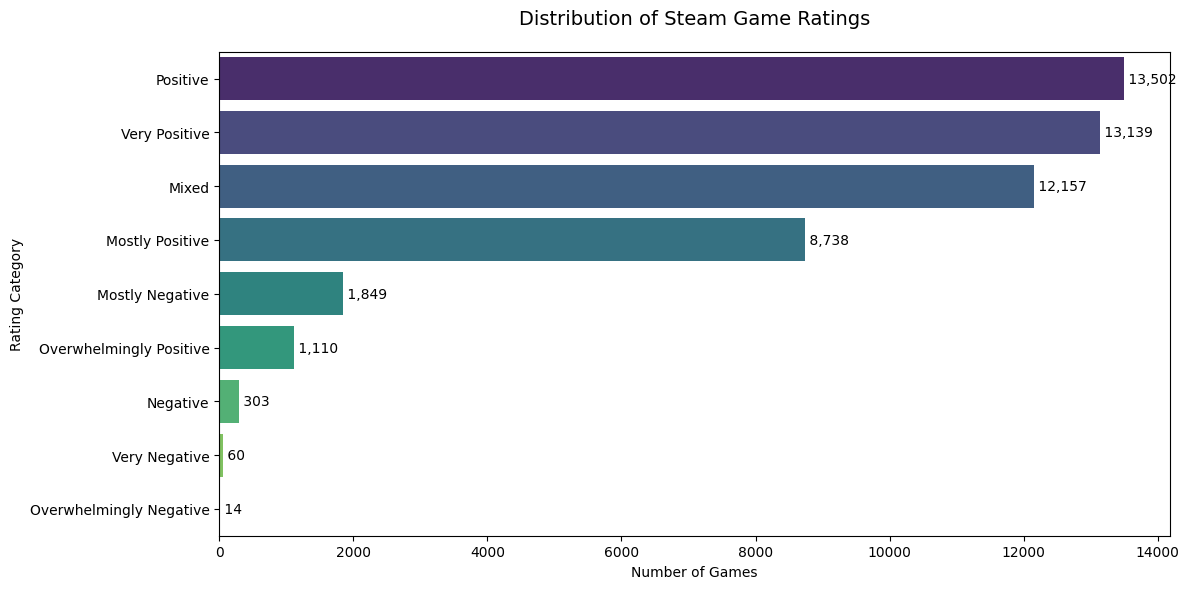

In [13]:
# Create value counts series and reset index to convert to DataFrame
ratings_df = games_df['rating'].value_counts().reset_index()
ratings_df.columns = ['Rating', 'Count']

plt.figure(figsize=(12, 6))
sns.barplot(data=ratings_df, 
           x='Count', 
           y='Rating',
           palette='viridis')

plt.title('Distribution of Steam Game Ratings', pad=20, size=14)
plt.xlabel('Number of Games')
plt.ylabel('Rating Category')

# Add value labels
for i, v in enumerate(ratings_df['Count']):
    plt.text(v, i, f' {v:,}', va='center')

plt.tight_layout()
plt.show()

In [14]:
# Análisis de precios
print("\nEstadísticas de precios:")
print(games_df[['price_final', 'price_original']].describe())


Estadísticas de precios:
        price_final  price_original
count  50872.000000    50872.000000
mean       8.620325        8.726788
std       11.514164       11.507021
min        0.000000        0.000000
25%        0.990000        0.990000
50%        4.990000        4.990000
75%       10.990000       11.990000
max      299.990000      299.990000


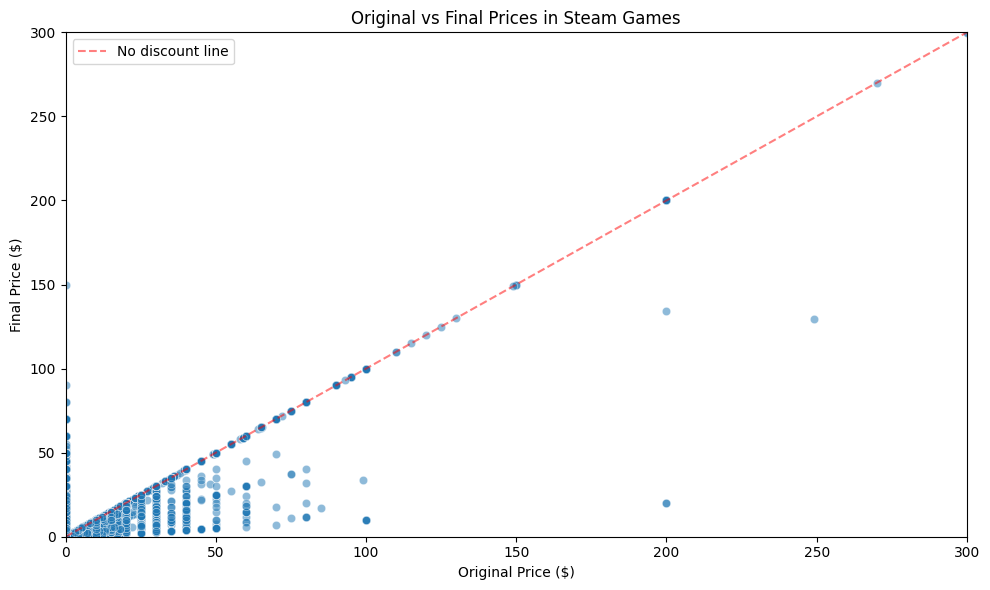

In [15]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=games_df, 
                x='price_original', 
                y='price_final',
                alpha=0.5)

# Add diagonal line representing equal prices
max_price = max(games_df['price_original'].max(), games_df['price_final'].max())
plt.plot([0, max_price], [0, max_price], 'r--', alpha=0.5, label='No discount line')

plt.title('Original vs Final Prices in Steam Games')
plt.xlabel('Original Price ($)')
plt.ylabel('Final Price ($)')
plt.legend()

# Limit axes to focus on main price range (excluding outliers)
plt.xlim(0, 300)
plt.ylim(0, 300)

plt.tight_layout()
plt.show()

In [16]:
# Análisis de recomendaciones
print("\nDistribución de recomendaciones:")
print(recommendations_df['is_recommended'].value_counts(normalize=True))


Distribución de recomendaciones:
is_recommended
True     0.857844
False    0.142156
Name: proportion, dtype: float64


In [17]:
# Análisis de horas jugadas
print("\nEstadísticas de horas jugadas:")
print(recommendations_df['hours'].describe())


Estadísticas de horas jugadas:
count    4.115479e+07
mean     1.006022e+02
std      1.761675e+02
min      0.000000e+00
25%      7.800000e+00
50%      2.730000e+01
75%      9.920000e+01
max      1.000000e+03
Name: hours, dtype: float64


### Verificamos la integridad de referencias entre los datasets
Nos aseguramos de que los juegos y los usuarios referenciados en reseñas existen en el dataset de juegos y en el de usuarios

In [18]:
# Verificar si todos los app_id en recommendations existen en games
games_apps = set(games_df['app_id'])
recommendations_apps = set(recommendations_df['app_id'])
print("\nJuegos en recommendations pero no en games:", len(recommendations_apps - games_apps))


Juegos en recommendations pero no en games: 0


In [19]:
# Verificar si todos los user_id en recommendations existen en users
users_ids = set(users_df['user_id'])
recommendations_users = set(recommendations_df['user_id'])
print("Usuarios en recommendations pero no en users:", len(recommendations_users - users_ids))

Usuarios en recommendations pero no en users: 0


## Se va a crear un modelo capaz de predecir el rating que tendrá un juego ("Very Positive", "Mixed", etc.) 
## Son 9 clases 
- Positive                   13502
- Very Positive              13139
- Mixed                      12157
- Mostly Positive             8738
- Mostly Negative             1849
- Overwhelmingly Positive     1110
- Negative                     303
- Very Negative                 60
- Overwhelmingly Negative       14

## Features de entrada
- Título del juego
- Precio
- Plataformas soportadas (win, mac, linux)
- Tiempo en el mercado
- Métricas agregadas de reviews (horas promedio jugadas, cantidad de reviews útiles)

## Preprocesamiendo de los datos

### Creamos features en base a las recomendaciones de los juegos

In [20]:
game_metrics = recommendations_df.groupby('app_id').agg({
    'hours': ['mean', 'median', 'std'],
    'is_recommended': 'mean',
    'helpful': 'mean',
    'funny': 'mean'
}).reset_index()

# Aplanar los nombres de las columnas
game_metrics.columns = ['app_id', 'avg_hours', 'median_hours', 'std_hours', 
                        'recommendation_ratio', 'avg_helpful', 'avg_funny']

### Procesamos las fechas para calcular el tiempo que el juego ha estado en el mercado

In [21]:
games_df['date_release'] = pd.to_datetime(games_df['date_release'])
reference_date = pd.to_datetime('2024-11-01')  # Fecha de referencia
games_df['days_in_market'] = (reference_date - games_df['date_release']).dt.days

### Unimos los nuevos features en un dataset final usando como base el de games

In [22]:
final_df = games_df.merge(game_metrics, on='app_id', how='left')
    
# 4. Rellenar valores nulos
final_df = final_df.fillna({
    'avg_hours': 0,
    'median_hours': 0,
    'std_hours': 0,
    'recommendation_ratio': 0.5,
    'avg_helpful': 0,
    'avg_funny': 0
})

In [23]:
final_df.head()

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,days_in_market,avg_hours,median_hours,std_hours,recommendation_ratio,avg_helpful,avg_funny
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,0.0,True,5824,18.967912,12.9,41.722269,0.845789,5.392052,0.612100
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,0.0,True,4839,0.000000,0.0,0.000000,0.500000,0.000000,0.000000
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,0.0,True,4209,20.413294,6.9,53.295053,0.908541,1.434682,0.450382
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,0.0,True,3636,10.776625,8.1,15.421851,0.625998,6.778791,0.815279
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,0.0,True,3658,40.621691,23.4,54.860085,0.885567,2.530928,0.698351


In [24]:
final_df.describe()

,app_id,date_release,positive_ratio,user_reviews,price_final,price_original,discount,days_in_market,avg_hours,median_hours,std_hours,recommendation_ratio,avg_helpful,avg_funny
count,5.087200e+04,50872,50872.000000,5.087200e+04,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000,50872.000000
mean,1.055224e+06,2019-03-13 03:53:57.112753664,77.052033,1.824425e+03,8.620325,8.726788,5.592212,2059.837533,12.017546,5.630656,21.209406,0.697721,2.927259,0.496619
min,1.000000e+01,1997-06-30 00:00:00,0.000000,1.000000e+01,0.000000,0.000000,0.000000,374.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.287375e+05,2017-03-21 00:00:00,67.000000,1.900000e+01,0.990000,0.990000,0.000000,1137.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
50%,9.860850e+05,2019-08-23 00:00:00,81.000000,4.900000e+01,4.990000,4.990000,0.000000,1897.000000,3.436826,1.500000,4.186043,0.714286,2.178243,0.131972
75%,1.524895e+06,2021-09-21 00:00:00,91.000000,2.060000e+02,10.990000,11.990000,0.000000,2782.000000,10.730804,5.000000,21.601544,0.881546,4.000000,0.482362
max,2.599300e+06,2023-10-24 00:00:00,100.000000,7.494460e+06,299.990000,299.990000,90.000000,9986.000000,487.000000,511.500000,495.120177,1.000000,268.285714,266.285714
std,6.103249e+05,NaN,18.253592,4.007352e+04,11.514164,11.507021,18.606679,1125.133076,28.005183,16.127001,41.136308,0.204218,4.689921,2.481174


In [25]:
final_df.max()

app_id                              2599300
title                      🧠 OUT OF THE BOX
date_release            2023-10-24 00:00:00
win                                    True
mac                                    True
linux                                  True
rating                        Very Positive
positive_ratio                          100
user_reviews                        7494460
price_final                          299.99
price_original                       299.99
discount                               90.0
steam_deck                             True
days_in_market                         9986
avg_hours                             487.0
median_hours                          511.5
std_hours                        495.120177
recommendation_ratio                    1.0
avg_helpful                      268.285714
avg_funny                        266.285714
dtype: object

### Se encontró un juego que posee métricas exageradas, al compararlo con Steam nos dimos cuenta de que parece ser un error
En base a esto imprimimos todos los juegos que tienen un precion final mayor a 70

In [26]:
juegos_filtrados = final_df[final_df['price_final'] > 70]

In [27]:
juegos_filtrados

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,days_in_market,avg_hours,median_hours,std_hours,recommendation_ratio,avg_helpful,avg_funny
81,438450,3DF Zephyr Lite Steam Edition,2016-02-02,True,False,False,Very Positive,96,58,199.99,199.99,0.0,True,3195,243.356250,121.35,265.982864,1.000000,4.979167,0.750000
144,537770,Gal*Gun: Double Peace - 'Pheromone Z' Item,2016-10-20,True,False,False,Positive,91,12,89.99,89.99,0.0,True,2934,0.000000,0.00,0.000000,0.500000,0.000000,0.000000
190,554820,VideoPad Video Editor,2016-12-01,True,True,False,Very Positive,80,51,99.99,99.99,0.0,True,2892,221.103030,130.70,238.796225,0.787879,3.212121,0.242424
403,1076160,Command: Modern Operations,2019-11-14,True,False,False,Very Positive,84,897,79.99,79.99,0.0,True,1814,126.815050,49.00,186.176124,0.859532,12.749164,5.050167
675,1182920,Movavi Video Editor Plus 2020 - Video Editing ...,2019-11-25,True,True,False,Very Positive,80,874,74.99,74.99,0.0,True,1803,111.442762,56.80,161.577714,0.788419,1.817372,0.227171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47765,411893,DCS: F-14A/B Tomcat,2019-03-13,True,False,False,Very Positive,92,555,79.99,79.99,0.0,True,2060,0.000000,0.00,0.000000,0.500000,0.000000,0.000000
48354,1096900,RPG Maker MZ,2020-08-27,True,True,False,Very Positive,83,1070,80.00,0.00,0.0,True,1527,186.038028,72.85,249.288267,0.791080,16.969484,3.521127
49167,2199970,Substance 3D Painter 2023,2023-01-23,True,True,True,Very Positive,85,148,150.00,0.00,0.0,True,648,0.000000,0.00,0.000000,0.500000,0.000000,0.000000
49310,2070990,VEGAS Edit 20 Steam Edition,2022-11-01,True,False,False,Mixed,66,21,129.48,249.00,48.0,True,731,68.566667,5.60,113.331475,0.666667,19.333333,5.333333


Al ser solo 150 juegos, decidimos tirarlos para evitar conflictor

In [28]:
final_df = final_df[final_df['price_final'] <= 70].reset_index(drop=True)


In [29]:
final_df = final_df[final_df['price_original'] <= 70].reset_index(drop=True)


In [30]:
final_df.max()

app_id                              2599300
title                      🧠 OUT OF THE BOX
date_release            2023-10-24 00:00:00
win                                    True
mac                                    True
linux                                  True
rating                        Very Positive
positive_ratio                          100
user_reviews                        7494460
price_final                            70.0
price_original                        69.99
discount                               90.0
steam_deck                             True
days_in_market                         9986
avg_hours                             487.0
median_hours                          511.5
std_hours                        495.120177
recommendation_ratio                    1.0
avg_helpful                      268.285714
avg_funny                        266.285714
dtype: object

### Parece ser que hay juegos con nombres repetidos, eliminamos aquellos que esten repetidos ya que solo son 121 títulos problemáticos

In [31]:
titulos_duplicados = final_df['title'].duplicated().sum()
print(f"Número de títulos duplicados: {titulos_duplicados}")
titulos_repetidos = final_df[final_df['title'].duplicated(keep=False)]['title'].unique()
print(f"Títulos duplicados: {titulos_repetidos}")

Número de títulos duplicados: 121
Títulos duplicados: ['Prison Wars' 'The Good Life' 'RUSH' 'Hide and Seek' 'Remnants'
 'Blade of Darkness' 'The Cleaner' 'Rogue' 'Lighthouse Keeper' 'Valor'
 'Last Stop' 'fishy' 'Flashback' 'The Hotel' '3D Organon Anatomy'
 'Minotaur' 'Northern Lights' 'First Snow' 'Momentum' 'Alter Ego'
 'The Backrooms' 'Locked Up' 'Get Stuffed!' 'Ascent' 'The Hunt' 'Hatch'
 'Lost' 'Warhammer Quest' 'Apollo 11 VR' 'Psych' 'Eternal Return'
 'Achievement Clicker' 'Call of Duty®' 'Causality' 'The Lost Village'
 'Resonance' 'Dead Forest' 'Lost Marbles' 'Wanderer' 'Castles' 'Grapple'
 'Chaos Theory' 'Dungeon Warriors' 'Bounce' 'Evolution' 'Zombie Survivors'
 'Ritual' 'Archery Simulator' 'Outpost' 'Shutter' 'The Line' 'The Village'
 'The Wanderer' 'Fantasy Gladiators' 'Cave Crawler' 'Cursed'
 'A Walk in the Woods' 'Dark Matter' 'Beyond the Wall' 'White Mirror'
 'Zombie Apocalypse' 'RIFT' 'STAY' 'Silent World' 'REALITY' 'Tomorrow'
 'Arachnophobia' 'Vaccine' 'Arena' 'Dog Adven

In [32]:
titulos_unicos = ~final_df['title'].duplicated(keep=False)

# Filtrar el DataFrame para conservar solo los títulos únicos
final_df = final_df[titulos_unicos].reset_index(drop=True)
final_df.describe()

,app_id,date_release,positive_ratio,user_reviews,price_final,price_original,discount,days_in_market,avg_hours,median_hours,std_hours,recommendation_ratio,avg_helpful,avg_funny
count,5.047200e+04,50472,50472.000000,5.047200e+04,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000,50472.000000
mean,1.053253e+06,2019-03-10 18:46:25.164051456,77.107149,1.827487e+03,8.334297,8.418423,5.593557,2062.217764,11.961956,5.609096,21.154918,0.698100,2.921674,0.494605
min,1.000000e+01,1997-06-30 00:00:00,0.000000,1.000000e+01,0.000000,0.000000,0.000000,374.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.279475e+05,2017-03-17 00:00:00,67.000000,1.900000e+01,0.990000,0.990000,0.000000,1141.000000,0.000000,0.000000,0.000000,0.500000,0.000000,0.000000
50%,9.840950e+05,2019-08-20 00:00:00,81.000000,4.900000e+01,4.990000,4.990000,0.000000,1900.000000,3.460451,1.500000,4.203173,0.716655,2.176318,0.131313
75%,1.521705e+06,2021-09-17 00:00:00,91.000000,2.080000e+02,10.990000,11.990000,0.000000,2786.000000,10.753019,5.000000,21.654140,0.881903,4.000000,0.480000
max,2.599300e+06,2023-10-24 00:00:00,100.000000,7.494460e+06,70.000000,69.990000,90.000000,9986.000000,487.000000,511.500000,495.120177,1.000000,268.285714,266.285714
std,6.095610e+05,NaN,18.217559,4.018612e+04,9.882176,9.686554,18.599731,1125.329458,27.762187,16.033585,40.894435,0.204009,4.688425,2.486727


In [33]:
titulos_duplicados = final_df['title'].duplicated().sum()
print(f"Número de títulos duplicados: {titulos_duplicados}")
titulos_repetidos = final_df[final_df['title'].duplicated(keep=False)]['title'].unique()
print(f"Títulos duplicados: {titulos_repetidos}")

Número de títulos duplicados: 0
Títulos duplicados: []


### Definimos las features que se usarán para el modelo

In [34]:
features = [
    'price_final', 'price_original', 'discount',
    'win', 'mac', 'linux', 'steam_deck',
    'days_in_market',
    'avg_hours', 'median_hours', 'std_hours',
    'recommendation_ratio', 'avg_helpful', 'avg_funny'
]

### Por los valores tan diferentes que tenemos en el dataset, normalizamos los datos para que puedan ser usados por el modelo sin problemas y no haya valores extremos que hagan que los valores menores no tengan importancia

In [35]:
scaler = StandardScaler()
numeric_features = [
    'price_final', 'price_original', 'discount',
    'days_in_market', 'avg_hours', 'median_hours', 'std_hours',
    'recommendation_ratio', 'avg_helpful', 'avg_funny'
]
final_df[numeric_features] = scaler.fit_transform(final_df[numeric_features])

### Pasamos la compatibilidad con diferentes plataformas a que sean booleanas, 0 o 1

In [36]:
bool_features = ['win', 'mac', 'linux', 'steam_deck']
final_df[bool_features] = final_df[bool_features].astype(int)

### Preparamos la variable dependiente (y)

In [37]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(final_df['rating'])
y = label_encoder.fit_transform(final_df['rating'])

### Preparamos las features (x)

In [38]:
X = final_df[features].values

# Embeddings

### Limpiamos los títulos

In [39]:
import torch
from torch.nn.utils.rnn import pad_sequence

In [40]:
def clean_title(title):
    """
    Limpia y normaliza el título del juego.
    
    Args:
        title (str): Título original del juego
        
    Returns:
        str: Título limpio y normalizado
    """
    # Convertir a minúsculas
    title = title.lower()
    
    # Eliminar caracteres especiales y símbolos, manteniendo espacios
    title = re.sub(r'[^\w\s]', ' ', title)
    
    # Eliminar espacios múltiples
    title = ' '.join(title.split())
    
    return title

# Aplicar la limpieza a los títulos
final_df['clean_title'] = final_df['title'].apply(clean_title)

### Creamos y configuramos el tokenizer (TorchText no me funciona)

In [41]:
class SimpleTokenizer:
    def __init__(self, num_words=10000, oov_token='<OOV>'):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {}
        self.index_word = {}
        self.word_counts = {}
        
    def fit_on_texts(self, texts):
        # Contar todas las palabras
        for text in texts:
            for word in text.split():
                self.word_counts[word] = self.word_counts.get(word, 0) + 1
        
        # Ordenar por frecuencia y tomar los num_words más frecuentes
        sorted_words = sorted(self.word_counts.items(), 
                            key=lambda x: x[1], 
                            reverse=True)[:self.num_words-1]
        
        # Crear mappings
        self.word_index = {self.oov_token: 0}
        self.index_word = {0: self.oov_token}
        
        for idx, (word, _) in enumerate(sorted_words, 1):
            self.word_index[word] = idx
            self.index_word[idx] = word
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            sequence = []
            for word in text.split():
                sequence.append(self.word_index.get(word, 0))  # 0 es OOV
            sequences.append(sequence)
        return sequences

### Función para hacer padding

In [42]:
def pad_sequences(sequences, max_len=None, padding_value=0):
    """
    Hace padding de las secuencias a una longitud máxima
    """
    if max_len is None:
        max_len = max(len(seq) for seq in sequences)
    
    padded_sequences = []
    for seq in sequences:
        if len(seq) > max_len:
            padded_sequences.append(seq[:max_len])
        else:
            padded_sequences.append(seq + [padding_value] * (max_len - len(seq)))
    
    return torch.tensor(padded_sequences)

### Aplicamos la tokenización y el padding

In [43]:
# Aplicar la tokenización y padding
tokenizer = SimpleTokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(final_df['clean_title'])
sequences = tokenizer.texts_to_sequences(final_df['clean_title'])
padded_sequences = pad_sequences(sequences, max_len=10)  # Usamos max_len=10 como en tu código original

### Ejemplo de procesamiento

In [44]:
# Veamos algunos stats
print(f"Forma de las secuencias padding: {padded_sequences.shape}")
vocab_size = len(tokenizer.word_index)
print(f"Tamaño del vocabulario: {vocab_size}")

# Veamos un ejemplo
example_idx = 0
print("\nEjemplo de tokenización:")
print(f"Texto original: {final_df['clean_title'].iloc[example_idx]}")
print(f"Secuencia tokenizada: {sequences[example_idx]}")
print(f"Secuencia con padding: {padded_sequences[example_idx].tolist()}")

# Guardamos algunas variables importantes para el modelo
max_length = padded_sequences.shape[1]  # Longitud máxima de las secuencias
embedding_dim = 32  # Dimensión del embedding (igual que en tu código original)

print(f"\nVariables importantes:")
print(f"Máxima longitud de secuencia: {max_length}")
print(f"Dimensión del embedding: {embedding_dim}")
print(f"Tamaño del vocabulario: {vocab_size}")

Forma de las secuencias padding: torch.Size([50472, 10])
Tamaño del vocabulario: 10000

Ejemplo de tokenización:
Texto original: prince of persia warrior within
Secuencia tokenizada: [1275, 2, 2533, 243, 657]
Secuencia con padding: [1275, 2, 2533, 243, 657, 0, 0, 0, 0, 0]

Variables importantes:
Máxima longitud de secuencia: 10
Dimensión del embedding: 32
Tamaño del vocabulario: 10000


In [45]:
final_df

,app_id,title,date_release,win,mac,linux,rating,positive_ratio,user_reviews,price_final,price_original,discount,steam_deck,days_in_market,avg_hours,median_hours,std_hours,recommendation_ratio,avg_helpful,avg_funny,clean_title
0,13500,Prince of Persia: Warrior Within™,2008-11-21,1,0,0,Very Positive,84,2199,0.167546,0.162245,-0.300736,1,3.342861,0.252359,0.454731,0.502943,0.723937,0.526915,0.047249,prince of persia warrior within
1,22364,BRINK: Agents of Change,2011-08-03,1,0,0,Positive,85,21,-0.540807,-0.560414,-0.300736,1,2.467553,-0.430877,-0.349838,-0.517311,-0.971047,-0.623174,-0.198900,brink agents of change
2,113020,Monaco: What's Yours Is Mine,2013-04-24,1,1,1,Very Positive,92,3722,0.673512,0.678429,-0.300736,1,1.907711,0.304422,0.080513,0.785937,1.031535,-0.317165,-0.017784,monaco what s yours is mine
3,226560,Escape Dead Island,2014-11-18,1,0,0,Mixed,61,873,0.673512,0.678429,-0.300736,1,1.398522,-0.042696,0.155357,-0.140193,-0.353433,0.822697,0.128956,escape dead island
4,249050,Dungeon of the ENDLESS™,2014-10-27,1,1,0,Very Positive,88,8784,0.369933,0.368719,-0.300736,1,1.418072,1.032340,1.109613,0.824208,0.918921,-0.083344,0.081934,dungeon of the endless
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50467,2296380,I Expect You To Die 3: Cog in the Machine,2023-09-28,1,0,0,Very Positive,96,101,1.382877,-0.869092,-0.300736,1,-1.477109,-0.430877,-0.349838,-0.517311,-0.971047,-0.623174,-0.198900,i expect you to die 3 cog in the machine
50468,1272080,PAYDAY 3,2023-09-21,1,0,0,Mostly Negative,38,29458,3.204357,-0.869092,-0.300736,1,-1.470889,-0.430877,-0.349838,-0.517311,-0.971047,-0.623174,-0.198900,payday 3
50469,1402110,Eternights,2023-09-11,1,0,0,Very Positive,89,1128,2.192424,-0.869092,-0.300736,1,-1.462002,-0.430877,-0.349838,-0.517311,-0.971047,-0.623174,-0.198900,eternights
50470,2272250,Forgive Me Father 2,2023-10-19,1,0,0,Very Positive,95,82,0.876911,-0.869092,-0.300736,1,-1.495770,-0.430877,-0.349838,-0.517311,-0.971047,-0.623174,-0.198900,forgive me father 2


# Creamos dataset personalizado

In [47]:
class GameDataset(Dataset):
    def __init__(self, features, sequences, labels):
        self.features = features
        self.sequences = sequences
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'features': self.features[idx],
            'sequence': self.sequences[idx],
            'label': self.labels[idx]
        }

# Modelo 1 ------------------------------------------------

### Separamos los datos en Train 60%, Validation 20% y Test 20%

In [48]:
# Dividir en train/validation/test (60%/20%/20%)
X_temp, X_test, y_temp, y_test, seq_temp, seq_test = train_test_split(
    X, y, padded_sequences, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val, seq_train, seq_val = train_test_split(
    X_temp, y_temp, seq_temp, test_size=0.25, random_state=42
)

print(f"Dimensiones de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Dimensiones de los datos:
X_train: (30282, 14)
X_val: (10095, 14)
X_test: (10095, 14)


### Convertimos a tensores de PyTorch

In [49]:
# Convertimos a tensores de PyTorch
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

seq_train = torch.LongTensor(seq_train)
seq_val = torch.LongTensor(seq_val)
seq_test = torch.LongTensor(seq_test)

### Dataloaders

In [50]:
batch_size = 500
train_dataset = GameDataset(X_train, seq_train, y_train)
val_dataset = GameDataset(X_val, seq_val, y_val)
test_dataset = GameDataset(X_test, seq_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Definimos el modelo

In [51]:
class GameRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, num_features, num_classes):
        super().__init__()
        
        # Embedding para los títulos
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        # Calculamos el tamaño del embedding aplanado
        self.flat_embed_size = max_length * embedding_dim
        
        # Capa para features numéricas
        self.numeric_layer = nn.Sequential(
            nn.Linear(num_features, 64), # Reducimos las features a 64 dimensiones
            nn.ReLU(), # Función de activación no lineal
            nn.BatchNorm1d(64) # Normalización de las activaciones
        )
        
        # Capas combinadas después de la concatenación
        self.combined_layers = nn.Sequential(
            nn.Linear(self.flat_embed_size + 64, 128), # Primera capa densa
            nn.ReLU(),
            nn.Dropout(0.3), # Evitamos overfitting
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 64), # Segunda capa densa
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, num_classes)
        )
        
    def forward(self, sequences, features):
        # Procesar títulos
        embedded = self.embedding(sequences)
        flat_embedded = embedded.view(embedded.size(0), -1)
        
        # Procesar features numéricas
        numeric_out = self.numeric_layer(features)
        
        # Combinar ambos caminos
        combined = torch.cat((flat_embedded, numeric_out), dim=1)
        
        # Capas finales
        return self.combined_layers(combined)

### Inicializamos el modelo

In [52]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GameRatingModel(
    vocab_size=vocab_size,  # Del tokenizer
    embedding_dim=32,
    max_length=10,  # Longitud máxima de las secuencias
    num_features=X_train.shape[1],
    num_classes=len(label_encoder.classes_)
).to(device)

### Configuramos el entrenamiento

In [53]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

### Función de entrenamiento


In [54]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_model_state = None
    
    # Listas para guardar el historial
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        # Only show progress bar for first and last epoch
        if epoch <= 5 or epoch >= num_epochs-5:
            iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        else:
            iterator = train_loader
        
        for batch in iterator:
            features = batch['features'].to(device)
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences, features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
            
        train_loss = train_loss/len(train_loader)
        train_acc = 100.*train_correct/train_total
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                sequences = batch['sequence'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(sequences, features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
                
        val_loss = val_loss/len(val_loader)
        val_acc = 100.*val_correct/val_total
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        
    # Visualizar el historial
    plt.figure(figsize=(15, 5))
    
    # Subplot para Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot para Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, history

### Entrenando el modelo

Iniciando entrenamiento...


Epoch 1/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 124.77it/s]


Epoch 1/50:
Train Loss: 1.8507 | Train Acc: 38.32%
Val Loss: 1.4809 | Val Acc: 49.54%


Epoch 2/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 374.67it/s]


Epoch 2/50:
Train Loss: 1.3705 | Train Acc: 52.63%
Val Loss: 1.2607 | Val Acc: 53.09%


Epoch 3/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 312.14it/s]


Epoch 3/50:
Train Loss: 1.1978 | Train Acc: 56.01%
Val Loss: 1.1592 | Val Acc: 55.24%


Epoch 4/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 381.40it/s]


Epoch 4/50:
Train Loss: 1.1348 | Train Acc: 56.97%
Val Loss: 1.1559 | Val Acc: 55.28%


Epoch 5/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 301.75it/s]


Epoch 5/50:
Train Loss: 1.0834 | Train Acc: 58.49%
Val Loss: 1.1214 | Val Acc: 55.87%


Epoch 6/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 369.34it/s]


Epoch 6/50:
Train Loss: 1.0497 | Train Acc: 59.39%
Val Loss: 1.0985 | Val Acc: 56.73%
Epoch 7/50:
Train Loss: 1.0242 | Train Acc: 60.05%
Val Loss: 1.0929 | Val Acc: 56.58%
Epoch 8/50:
Train Loss: 1.0043 | Train Acc: 60.73%
Val Loss: 1.0844 | Val Acc: 56.59%
Epoch 9/50:
Train Loss: 0.9825 | Train Acc: 61.43%
Val Loss: 1.0935 | Val Acc: 56.89%
Epoch 10/50:
Train Loss: 0.9672 | Train Acc: 62.31%
Val Loss: 1.0869 | Val Acc: 56.64%
Epoch 11/50:
Train Loss: 0.9473 | Train Acc: 62.84%
Val Loss: 1.0912 | Val Acc: 56.74%
Epoch 12/50:
Train Loss: 0.9277 | Train Acc: 63.68%
Val Loss: 1.1042 | Val Acc: 56.89%
Epoch 13/50:
Train Loss: 0.9106 | Train Acc: 64.56%
Val Loss: 1.1028 | Val Acc: 56.45%
Epoch 14/50:
Train Loss: 0.8934 | Train Acc: 65.09%
Val Loss: 1.1221 | Val Acc: 56.86%
Epoch 15/50:
Train Loss: 0.8761 | Train Acc: 65.89%
Val Loss: 1.1261 | Val Acc: 56.69%
Epoch 16/50:
Train Loss: 0.8635 | Train Acc: 66.35%
Val Loss: 1.1299 | Val Acc: 56.72%
Epoch 17/50:
Train Loss: 0.8483 | Train Acc: 66

Epoch 46/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 328.75it/s]


Epoch 46/50:
Train Loss: 0.5352 | Train Acc: 79.60%
Val Loss: 1.5348 | Val Acc: 54.95%


Epoch 47/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 361.96it/s]


Epoch 47/50:
Train Loss: 0.5330 | Train Acc: 79.57%
Val Loss: 1.5793 | Val Acc: 54.61%


Epoch 48/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 328.29it/s]


Epoch 48/50:
Train Loss: 0.5258 | Train Acc: 79.94%
Val Loss: 1.6093 | Val Acc: 54.64%


Epoch 49/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 339.24it/s]


Epoch 49/50:
Train Loss: 0.5186 | Train Acc: 80.31%
Val Loss: 1.6226 | Val Acc: 54.65%


Epoch 50/50 - Training: 100%|██████████| 61/61 [00:00<00:00, 350.95it/s]


Epoch 50/50:
Train Loss: 0.5169 | Train Acc: 80.30%
Val Loss: 1.6245 | Val Acc: 54.61%


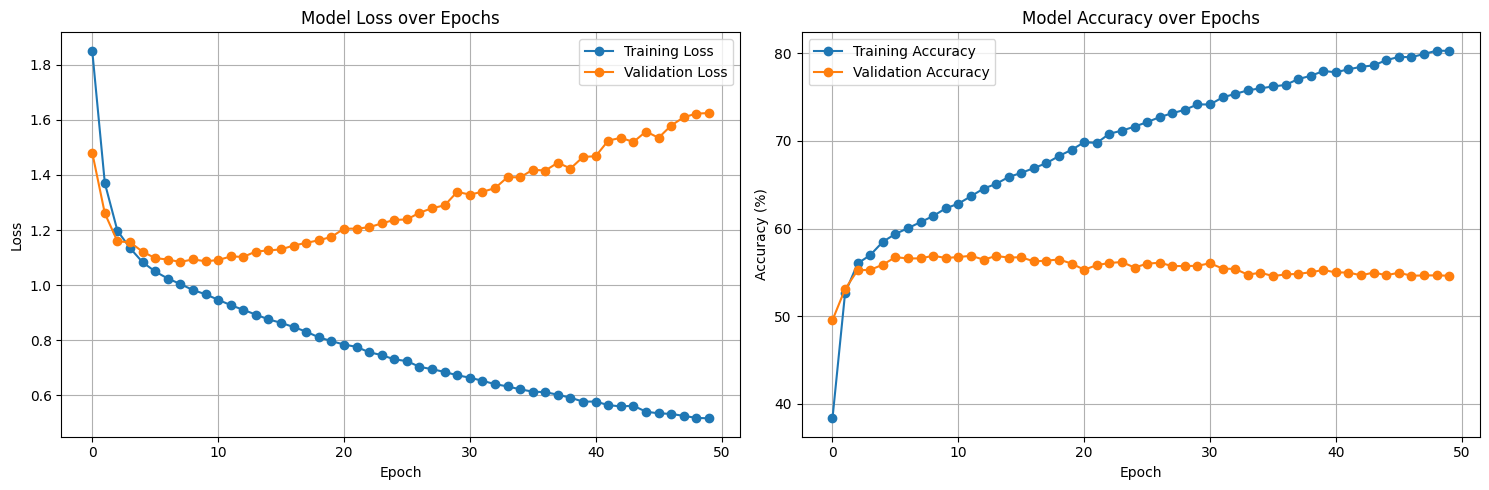

In [55]:
print("Iniciando entrenamiento...")
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=50
)

### Evaluamos el modelo

In [56]:
model.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for batch in test_loader:
        features = batch['features'].to(device)
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model(sequences, features)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

test_acc = 100.*test_correct/test_total
print(f'\nTest Accuracy: {test_acc:.2f}%')


Test Accuracy: 56.63%


In [57]:
torch.save(model.state_dict(), 'models/first-model.pth')

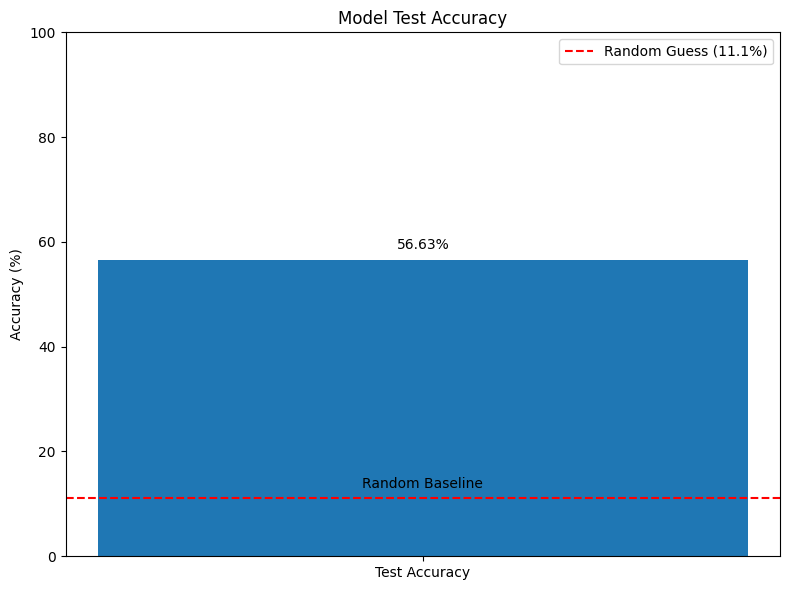

In [58]:
plt.figure(figsize=(8, 6))
plt.bar(['Test Accuracy'], [test_acc])
plt.axhline(y=100/9, color='r', linestyle='--', label='Random Guess (11.1%)')

plt.title('Model Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Añadir etiquetas
plt.text(0, test_acc + 2, f'{test_acc:.2f}%', ha='center')
plt.text(0, 100/9 + 2, 'Random Baseline', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

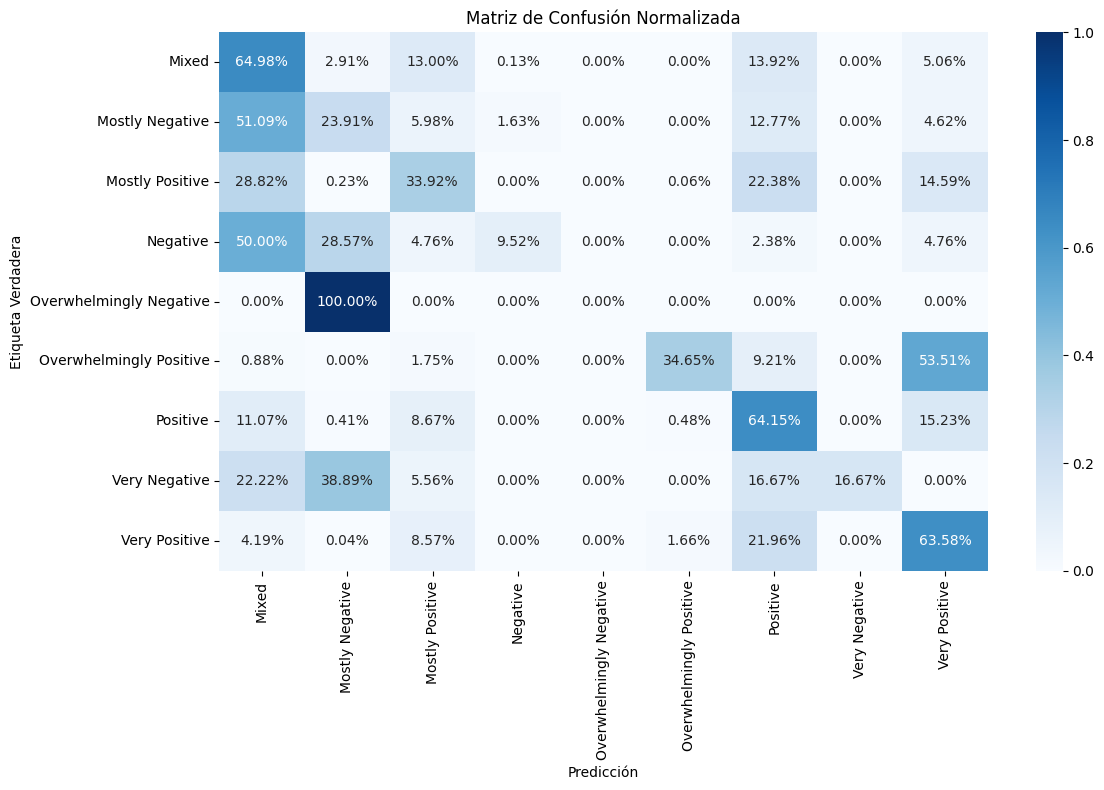


Reporte de Clasificación:
                         precision    recall  f1-score   support

                  Mixed      0.579     0.650     0.613      2370
        Mostly Negative      0.456     0.239     0.314       368
        Mostly Positive      0.420     0.339     0.375      1707
               Negative      0.308     0.095     0.145        42
Overwhelmingly Negative      0.000     0.000     0.000         1
Overwhelmingly Positive      0.577     0.346     0.433       228
               Positive      0.560     0.641     0.598      2711
          Very Negative      1.000     0.167     0.286        18
          Very Positive      0.646     0.636     0.641      2650

               accuracy                          0.566     10095
              macro avg      0.505     0.346     0.378     10095
           weighted avg      0.560     0.566     0.558     10095



/home/arturo/zProgramming/7th-deep-learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arturo/zProgramming/7th-deep-learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/arturo/zProgramming/7th-deep-learning/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [61]:
def create_confusion_matrix(model, test_loader, device, label_encoder):
    # Listas para almacenar predicciones y etiquetas verdaderas
    all_predictions = []
    all_labels = []
    
    # Obtener predicciones
    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            features = batch['features'].to(device)
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(sequences, features)
            _, predicted = outputs.max(1)
            
            # Mover a CPU y convertir a numpy
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Convertir a arrays de numpy
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    
    # Crear matriz de confusión
    cm = confusion_matrix(all_labels, all_predictions)
    
    # Normalizar la matriz de confusión
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Crear visualización
    plt.figure(figsize=(12, 8))
    
    # Plotear matriz de confusión normalizada
    sns.heatmap(cm_normalized, 
                annot=True, 
                fmt='.2%', 
                cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    
    plt.title('Matriz de Confusión Normalizada')
    plt.ylabel('Etiqueta Verdadera')
    plt.xlabel('Predicción')
    plt.tight_layout()
    plt.show()
    
    # Imprimir reporte de clasificación
    print("\nReporte de Clasificación:")
    print(classification_report(
        all_labels, 
        all_predictions, 
        target_names=label_encoder.classes_,
        digits=3
    ))
    
    return cm, cm_normalized

# Crear la matriz de confusión
cm, cm_normalized = create_confusion_matrix(model, test_loader, device, label_encoder)

# Interpretación modelo 1

- Training accuracy llega a un 80% aproximadamente
- Validation accuracy se mantiene entre un 50% y un 60%
- Test accuracy llega a un 55%

Se presenta una clara señal de overfitting, el modelo no maneja bien los datos nuevos que recibe. Este se aprende muy bien los datos con los que entrena, sin embargo no es capáz de predecir correctamente los datos que no ha visto antes (validation y test). Sin embargo, desde el inicio la validation se mantiene por el 50%, no importa todo el entrenamiento no se mejora la validación, esto puede presentar que el modelo es muy simple para el problema en cuestión. 

(Esto es malo)
- La arquitectura del modelo parece ser muy simple para el problema en cuestión
- A pesar de esto, solo aprende sobre el train dataset creando overfitting, nunca logra que la validation pase el 60%
- El batch size podría ser muy pequeño
- El embedding podría ser de una dimensión muy pequeña para captuar toda la información de los títulos

(Esto es bueno)
- Entre 9 clases, donde adivinar de manera aleatoria sería con un 11% de probabilidad, el modelo logra predecir correctamente el 50% de las veces.

Matriz de confusión
- Se ve que el modelo es realmente malo para predecir los casos "overwhelmingly negative", esto ya que esta categoría aparece solo en 14 casos. Además como está del lado negativo pone solo "Mostly negative" que aparece bastante más veces que la otra categoría.

# Modelo 2 (Mejorado, más simple) ---------------------------------------

In [62]:
# Dividir en train/validation/test (70%/20%/10%)
X_temp, X_test, y_temp, y_test, seq_temp, seq_test = train_test_split(
    X, y, padded_sequences, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val, seq_train, seq_val = train_test_split(
    X_temp, y_temp, seq_temp, test_size=0.25, random_state=42
)

print(f"Dimensiones de los datos:")
print(f"X_train: {X_train.shape}")
print(f"X_val: {X_val.shape}")
print(f"X_test: {X_test.shape}")

Dimensiones de los datos:
X_train: (30282, 14)
X_val: (10095, 14)
X_test: (10095, 14)


In [63]:
# Convertimos a tensores de PyTorch
X_train = torch.FloatTensor(X_train)
X_val = torch.FloatTensor(X_val)
X_test = torch.FloatTensor(X_test)

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

seq_train = torch.LongTensor(seq_train)
seq_val = torch.LongTensor(seq_val)
seq_test = torch.LongTensor(seq_test)

In [64]:
batch_size = 40
train_dataset = GameDataset(X_train, seq_train, y_train)
val_dataset = GameDataset(X_val, seq_val, y_val)
test_dataset = GameDataset(X_test, seq_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [65]:
class RobustScaler:
    def __init__(self):
        self.q1 = None
        self.q3 = None
        self.iqr = None
        self.median = None
    
    def fit(self, data):
        self.q1 = np.percentile(data, 25, axis=0)
        self.q3 = np.percentile(data, 75, axis=0)
        self.iqr = self.q3 - self.q1
        self.median = np.median(data, axis=0)
    
    def transform(self, data):
        return (data - self.median) / (self.iqr + 1e-8)

# Aplicar a las features numéricas
numeric_features = [
    'price_final', 'price_original', 'discount',
    'days_in_market', 'avg_hours', 'median_hours', 'std_hours',
    'recommendation_ratio', 'avg_helpful', 'avg_funny'
]

scaler = RobustScaler()
scaler.fit(final_df[numeric_features])
final_df[numeric_features] = scaler.transform(final_df[numeric_features])

### Implementamos residual block para que el gradiente pueda fluir por las capas sin que llegue a las últimas y haga cambios insignificantes

In [66]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim),
            nn.ReLU(),
            nn.BatchNorm1d(dim),
            nn.Dropout(0.2),
            nn.Linear(dim, dim)
        )
    
    def forward(self, x):
        return x + self.layers(x)

In [67]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads=8):
        super().__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        
    def forward(self, x):
        attn_output, _ = self.attention(x, x, x)
        return self.norm(x + attn_output)

### Disminuímos el número de capas para permitir que el modelo no aprenda en exceso el train-dataset

In [68]:
class SimplerGameRatingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, max_length, num_features, num_classes):
        super().__init__()
        
        # Reducir dimensión del embedding a la mitad
        self.embedding_dim = embedding_dim // 2
        self.embedding = nn.Embedding(vocab_size, self.embedding_dim)
        
        # Procesamiento de títulos simplificado
        self.title_dim = max_length * self.embedding_dim
        self.title_processing = nn.Sequential(
            nn.Linear(self.title_dim, 64),  # Reducido de 256 a 64
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3)
        )
        
        # Procesamiento numérico simplificado
        self.numeric_processing = nn.Sequential(
            nn.Linear(num_features, 32),  # Reducido de 128 a 32
            nn.ReLU(),
            nn.BatchNorm1d(32)
        )
        
        # Capas combinadas simplificadas
        self.combined_layers = nn.Sequential(
            nn.Linear(64 + 32, 64),  # Una sola capa oculta
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.5),  # Aumentado dropout
            nn.Linear(64, num_classes)
        )
        
    def forward(self, sequences, features):
        # Procesar títulos
        embedded = self.embedding(sequences)
        flat_embedded = embedded.reshape(embedded.size(0), -1)
        title_features = self.title_processing(flat_embedded)
        
        # Procesar features numéricas
        numeric_features = self.numeric_processing(features)
        
        # Combinar y procesar
        combined = torch.cat((title_features, numeric_features), dim=1)
        return self.combined_layers(combined)

### Agregamos early stopping para que el modelo se detenga durante el entrenamiento si detecta un retroceso considerable durante cierto número de épocas (10)

In [69]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0, mode='min'):
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model = None
    
    def __call__(self, current_value, model):
        if self.best_loss is None:
            self.best_loss = current_value
            self.best_model = model.state_dict().copy()
            return
        
        if self.mode == 'min':
            if current_value < self.best_loss - self.min_delta:
                self.best_loss = current_value
                self.counter = 0
                self.best_model = model.state_dict().copy()
            else:
                self.counter += 1
        else:  # mode == 'max'
            if current_value > self.best_loss + self.min_delta:
                self.best_loss = current_value
                self.counter = 0
                self.best_model = model.state_dict().copy()
            else:
                self.counter += 1
                
        if self.counter >= self.patience:
            self.early_stop = True

### Cambiamos de Adam a AdamW, lo que nos debería dar una mejor regularización
### Disminuímos el learning rate y aumentamos el número de épocas para tener un entrenamiento más detallado

In [70]:

def train_simpler_model(model, train_loader, val_loader, num_epochs=400):
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=0.0001,
        weight_decay=0.01,
        betas=(0.9, 0.999)
    )
    
    # Listas para guardar el historial
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Calcular pesos de clase
    class_counts = torch.bincount(y_train)
    class_weights = 1.0 / class_counts.float()
    class_weights = class_weights.to(device)
    
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    
    early_stopping = EarlyStopping(patience=10, mode='max')
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        
        if epoch <= 5 or epoch >= num_epochs-5:
            iterator = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training')
        else:
            iterator = train_loader
        
        for batch in iterator:
            features = batch['features'].to(device)
            sequences = batch['sequence'].to(device)
            labels = batch['label'].to(device)
            
            optimizer.zero_grad()
            outputs = model(sequences, features)
            loss = criterion(outputs, labels)
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()
        
        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                features = batch['features'].to(device)
                sequences = batch['sequence'].to(device)
                labels = batch['label'].to(device)
                
                outputs = model(sequences, features)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()
        
        # Métricas
        train_acc = 100.*train_correct/train_total
        val_acc = 100.*val_correct/val_total
        
        # Guardar historial
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss/len(train_loader):.4f} | Train Acc: {train_acc:.2f}%')
        print(f'Val Loss: {val_loss/len(val_loader):.4f} | Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        early_stopping(val_acc, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.best_model)
            break
    
    # Visualizar el historial
    plt.figure(figsize=(15, 5))
    
    # Subplot para Loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Model Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Subplot para Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy', marker='o')
    plt.plot(history['val_acc'], label='Validation Accuracy', marker='o')
    plt.title('Model Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return model, history

Epoch 1/400 - Training:   0%|          | 0/758 [00:00<?, ?it/s]

Epoch 1/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 690.09it/s]


Epoch 1/400:
Train Loss: 2.1785 | Train Acc: 18.04%
Val Loss: 1.9543 | Val Acc: 29.28%


Epoch 2/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 616.95it/s]


Epoch 2/400:
Train Loss: 1.8873 | Train Acc: 26.61%
Val Loss: 1.7313 | Val Acc: 32.87%


Epoch 3/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 698.76it/s]


Epoch 3/400:
Train Loss: 1.7502 | Train Acc: 31.95%
Val Loss: 1.6460 | Val Acc: 37.77%


Epoch 4/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 647.82it/s]


Epoch 4/400:
Train Loss: 1.6445 | Train Acc: 35.78%
Val Loss: 1.5671 | Val Acc: 42.11%


Epoch 5/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 644.22it/s]


Epoch 5/400:
Train Loss: 1.5745 | Train Acc: 38.83%
Val Loss: 1.5296 | Val Acc: 42.85%


Epoch 6/400 - Training: 100%|██████████| 758/758 [00:01<00:00, 690.35it/s]


Epoch 6/400:
Train Loss: 1.5338 | Train Acc: 40.49%
Val Loss: 1.4946 | Val Acc: 44.95%
Epoch 7/400:
Train Loss: 1.4984 | Train Acc: 42.01%
Val Loss: 1.4695 | Val Acc: 46.36%
Epoch 8/400:
Train Loss: 1.4721 | Train Acc: 43.52%
Val Loss: 1.4539 | Val Acc: 47.61%
Epoch 9/400:
Train Loss: 1.4274 | Train Acc: 44.24%
Val Loss: 1.4194 | Val Acc: 47.25%
Epoch 10/400:
Train Loss: 1.4138 | Train Acc: 44.70%
Val Loss: 1.4100 | Val Acc: 46.92%
Epoch 11/400:
Train Loss: 1.3946 | Train Acc: 45.80%
Val Loss: 1.4279 | Val Acc: 49.63%
Epoch 12/400:
Train Loss: 1.3788 | Train Acc: 46.34%
Val Loss: 1.4515 | Val Acc: 48.94%
Epoch 13/400:
Train Loss: 1.3523 | Train Acc: 47.70%
Val Loss: 1.4164 | Val Acc: 49.72%
Epoch 14/400:
Train Loss: 1.3305 | Train Acc: 47.90%
Val Loss: 1.4024 | Val Acc: 47.22%
Epoch 15/400:
Train Loss: 1.3084 | Train Acc: 48.03%
Val Loss: 1.4416 | Val Acc: 49.56%
Epoch 16/400:
Train Loss: 1.2867 | Train Acc: 49.27%
Val Loss: 1.4859 | Val Acc: 51.17%
Epoch 17/400:
Train Loss: 1.2903 | T

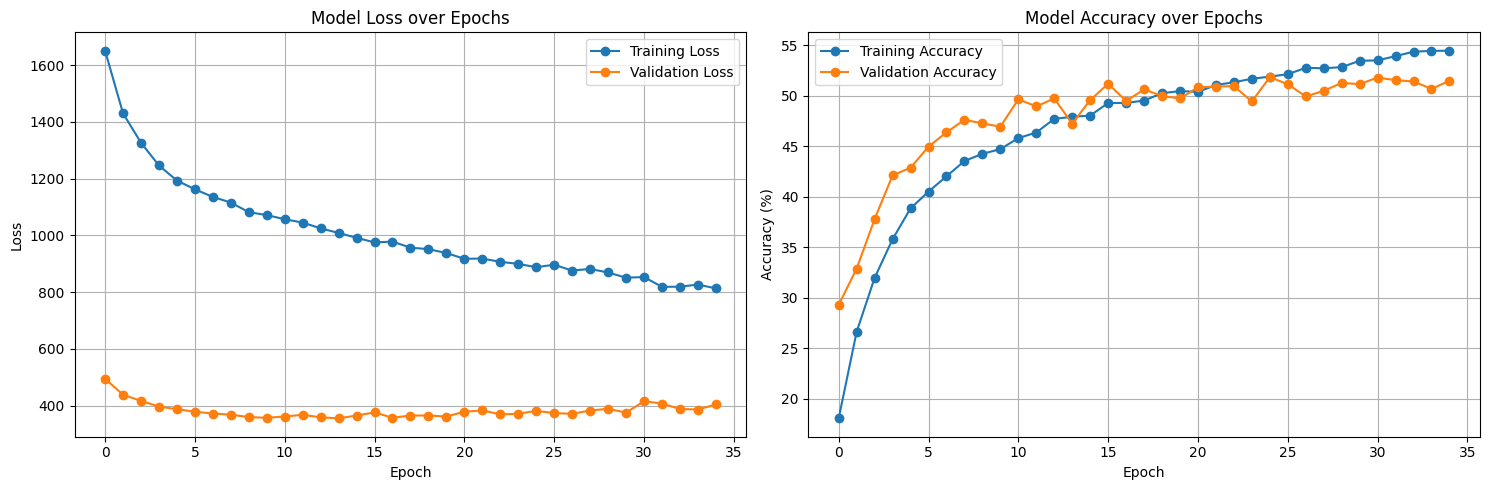

In [71]:
# Configuración
config = {
    'vocab_size': vocab_size,
    'embedding_dim': 256,
    'max_length': 10,
    'num_features': X_train.shape[1],
    'num_classes': len(label_encoder.classes_)
}

# Crear y entrenar modelo
model2 = SimplerGameRatingModel(**config).to(device)
model2, history2 = train_simpler_model(model2, train_loader, val_loader)

In [ ]:
model2.eval()
test_correct_2 = 0
test_total_2 = 0

with torch.no_grad():
    for batch in test_loader:
        features = batch['features'].to(device)
        sequences = batch['sequence'].to(device)
        labels = batch['label'].to(device)
        
        outputs = model2(sequences, features)
        _, predicted = outputs.max(1)
        test_total_2 += labels.size(0)
        test_correct_2 += predicted.eq(labels).sum().item()

test_acc_2 = 100.*test_correct_2/test_total_2
print(f'\nTest Accuracy: {test_acc_2:.2f}%')


Test Accuracy: 52.81%


In [73]:
torch.save(model2.state_dict(), 'models/second-model.pth')

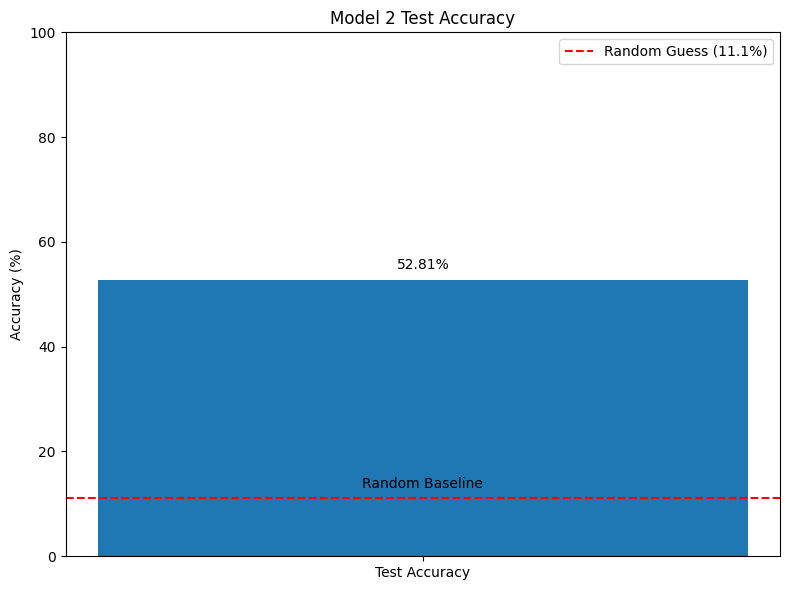

In [74]:
plt.figure(figsize=(8, 6))
plt.bar(['Test Accuracy'], [test_acc_2])
plt.axhline(y=100/9, color='r', linestyle='--', label='Random Guess (11.1%)')

plt.title('Model 2 Test Accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)

# Añadir etiquetas
plt.text(0, test_acc_2 + 2, f'{test_acc_2:.2f}%', ha='center')
plt.text(0, 100/9 + 2, 'Random Baseline', ha='center')

plt.legend()
plt.tight_layout()
plt.show()

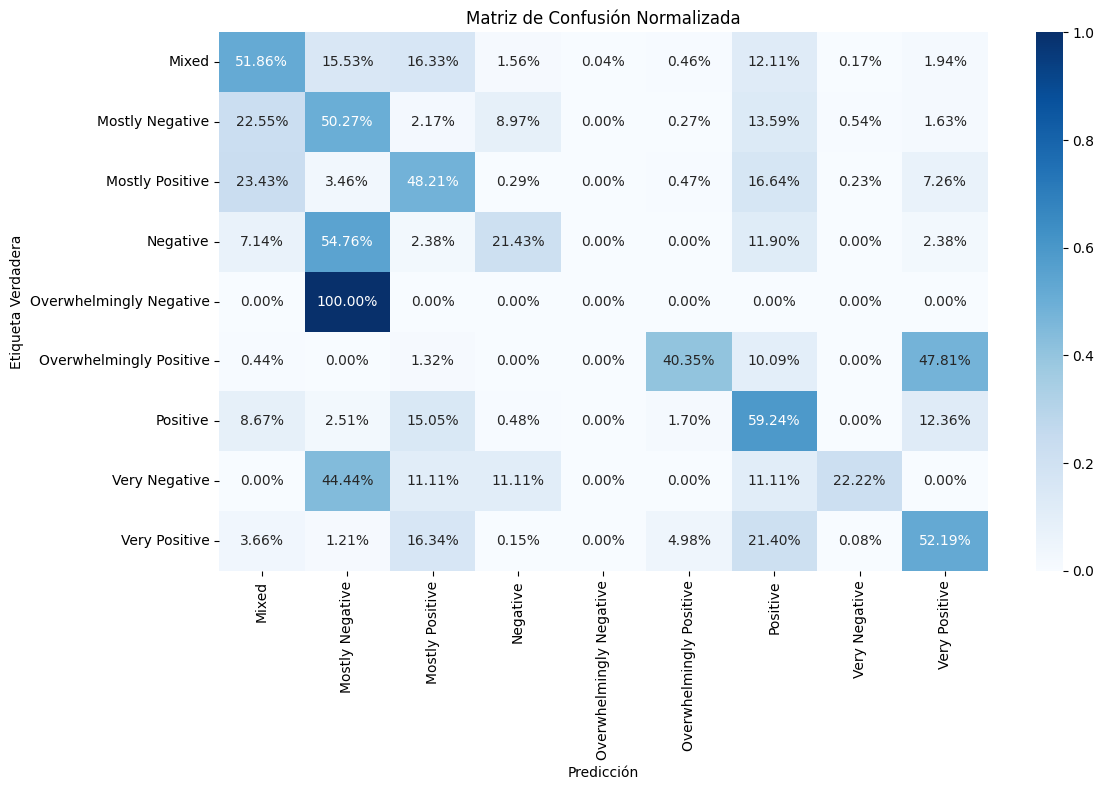


Reporte de Clasificación:
                         precision    recall  f1-score   support

                  Mixed      0.600     0.519     0.556      2370
        Mostly Negative      0.249     0.503     0.333       368
        Mostly Positive      0.399     0.482     0.436      1707
               Negative      0.087     0.214     0.124        42
Overwhelmingly Negative      0.000     0.000     0.000         1
Overwhelmingly Positive      0.317     0.404     0.355       228
               Positive      0.569     0.592     0.580      2711
          Very Negative      0.250     0.222     0.235        18
          Very Positive      0.690     0.522     0.594      2650

               accuracy                          0.528     10095
              macro avg      0.351     0.384     0.357     10095
           weighted avg      0.559     0.528     0.537     10095



In [75]:
# Crear la matriz de confusión
cm, cm_normalized = create_confusion_matrix(model2, test_loader, device, label_encoder)

# Interpretación modelo 2
## Okay, hay un cambio notorio

- Training accuracy llega a un 60% aproximadamente
- Validation accuracy se mantiene cerca del 55%
- Test accuracy cerca del 55%

En este caso se nota un ligero overfitting pero con mejores resultados que el modelo anterior. Esta vez ambos test y validation se mantienen pegados duarante todo el entrenamiento, y gracias al parado automático cuando empiezan a separarse el modelo se detiene por no ver progreso en cierto número de épocas.

(Esto es malo)
- Parece ser que al modelo de todas formas le cuesta progresar en la validation y en el test más allá del 55%

(Esto es bueno, sigue exactamente igual)
- Entre 9 clases, donde adivinar de manera aleatoria sería con un 11% de probabilidad, el modelo logra predecir correctamente el 55% de las veces.

Matriz de confusión
- Presenta resultados muy parecidos al modelo anterior, sin embargo los resultados de "Positive" se ven aún más correctos, mayoría de los negativos cayendo en "Mostly negative". Sigue presentando el mismo conflicto para detectar las "Overwhelmingly negative" debido a la falta de juegos que caigan en esta categoría.

- Training accuracy llega a un 60% aproximadamente
- Validation accuracy se mantiene cerca del 55%
- Test accuracy cerca del 55%

En este caso se nota un ligero overfitting pero con mejores resultados que el modelo anterior. Esta vez ambos test y validation se mantienen pegados duarante todo el entrenamiento, y gracias al parado automático cuando empiezan a separarse el modelo se detiene por no ver progreso en cierto número de épocas.

(Esto es malo)
- Parece ser que al modelo de todas formas le cuesta progresar en la validation y en el test más allá del 55%

(Esto es bueno, sigue exactamente igual)
- Entre 9 clases, donde adivinar de manera aleatoria sería con un 11% de probabilidad, el modelo logra predecir correctamente el 55% de las veces.

Matriz de confusión
- Presenta resultados muy parecidos al modelo anterior, sin embargo los resultados de "Positive" se ven aún más correctos, mayoría de los negativos cayendo en "Mostly negative". Sigue presentando el mismo conflicto para detectar las "Overwhelmingly negative" debido a la falta de juegos que caigan en esta categoría.